# Regular regression : RIDGE


0. Import usual librairies

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

  1. Load the Online news dataset from the src folder, and use this command to clean out column names ```data.columns = [name.strip() for name in data.columns]```

  The description of this dataset is contained in the .txt file present in the same folder.

use the command ```data = data.sample(1000, random_state = 0)``` to extract a 1000 observations sample.

  Take a moment to display data info in order to check for missing values. 
  Also just from the variables names we can anticipate that a number of variables will be collinear, remove those variables. Remove also "LDA_00", "rate_positive_words", "n_non_stop_words" that are also near collinear when given a small sample of data.


In [3]:
data = pd.read_csv("s3://full-stack-bigdata-datasets/Machine Learning Supervisé/Régression régularisées/news/OnlineNewsPopularity.csv")
data.columns = [name.strip() for name in data.columns]
data = data.sample(1000, random_state = 0)
data.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
18765,http://mashable.com/2014/01/13/nokia-first-and...,360.0,8.0,810.0,0.455696,1.0,0.623950,16.0,7.0,1.0,...,0.100000,0.6,-0.194444,-0.600000,-0.050,0.000000,0.000000,0.500000,0.000000,919
16349,http://mashable.com/2013/11/19/slow-motion-wed...,415.0,12.0,122.0,0.678571,1.0,0.783333,7.0,2.0,1.0,...,0.500000,1.0,-0.220000,-0.500000,-0.150,0.433333,0.066667,0.066667,0.066667,1600
27703,http://mashable.com/2014/06/25/conan-obrien-wo...,197.0,12.0,891.0,0.391455,1.0,0.483649,6.0,3.0,22.0,...,0.100000,1.0,-0.108333,-0.166667,-0.050,1.000000,-0.250000,0.500000,0.250000,11700
32947,http://mashable.com/2014/09/17/ios-8-without-d...,113.0,9.0,1323.0,0.380952,1.0,0.530740,31.0,11.0,13.0,...,0.062500,0.8,-0.144266,-0.500000,-0.050,0.000000,0.000000,0.500000,0.000000,18000
35434,http://mashable.com/2014/10/24/ebikes-commute-...,75.0,8.0,261.0,0.596154,1.0,0.721212,8.0,3.0,4.0,...,0.033333,1.0,-0.198611,-0.300000,-0.125,0.344444,-0.227778,0.155556,0.227778,5800


In [272]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 18765 to 937
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            1000 non-null   object 
 1   timedelta                      1000 non-null   float64
 2   n_tokens_title                 1000 non-null   float64
 3   n_tokens_content               1000 non-null   float64
 4   n_unique_tokens                1000 non-null   float64
 5   n_non_stop_words               1000 non-null   float64
 6   n_non_stop_unique_tokens       1000 non-null   float64
 7   num_hrefs                      1000 non-null   float64
 8   num_self_hrefs                 1000 non-null   float64
 9   num_imgs                       1000 non-null   float64
 10  num_videos                     1000 non-null   float64
 11  average_token_length           1000 non-null   float64
 12  num_keywords                   1000 non-null 

In [273]:
variables_to_keep = [col for col in data.columns if col not in ["weekday_is_sunday","is_weekend", "LDA_00", "rate_positive_words", "n_non_stop_words"]]
data = data.loc[:,variables_to_keep]

1bis. Display a graph with the distribution of the variable shares, what can you conclude from this graph?

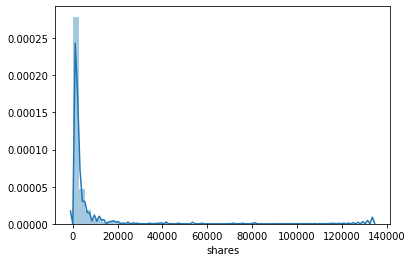

In [274]:
sns.distplot(data[data.columns[-1]])

The graph of the target variable's distribution indicates that the disribution is extremely skewed, very few very high values are present which would cause our data to be extremely hard to model. Therefore we need to exclude from the dataset the rows where Y takes extremely high values. In this type of situation it is common to convert the target variable to a logarithmic scale.

2. Create a dataframe containing the explanatory variables and another one containing only the target variable, which is the number of shares. Convert y to logarithmic scale using np.log10

In [275]:
y = data.iloc[:,-1]
y = np.log10(y)
X = data.iloc[:,1:-1]

In [276]:
y.head()

18765    2.963316
16349    3.204120
27703    4.068186
32947    4.255273
35434    3.763428
Name: shares, dtype: float64

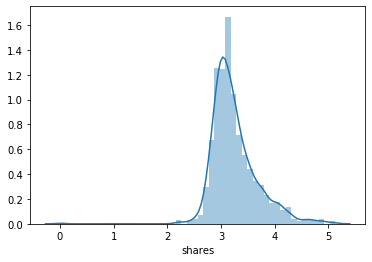

In [277]:
sns.distplot(y)

In [278]:
X.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
18765,360.0,8.0,810.0,0.455696,0.623950,16.0,7.0,1.0,0.0,4.943210,...,0.355966,0.100000,0.6,-0.194444,-0.600000,-0.050,0.000000,0.000000,0.500000,0.000000
16349,415.0,12.0,122.0,0.678571,0.783333,7.0,2.0,1.0,0.0,4.557377,...,0.666667,0.500000,1.0,-0.220000,-0.500000,-0.150,0.433333,0.066667,0.066667,0.066667
27703,197.0,12.0,891.0,0.391455,0.483649,6.0,3.0,22.0,2.0,4.712682,...,0.328018,0.100000,1.0,-0.108333,-0.166667,-0.050,1.000000,-0.250000,0.500000,0.250000
32947,113.0,9.0,1323.0,0.380952,0.530740,31.0,11.0,13.0,0.0,4.561602,...,0.359793,0.062500,0.8,-0.144266,-0.500000,-0.050,0.000000,0.000000,0.500000,0.000000
35434,75.0,8.0,261.0,0.596154,0.721212,8.0,3.0,4.0,0.0,4.601533,...,0.330556,0.033333,1.0,-0.198611,-0.300000,-0.125,0.344444,-0.227778,0.155556,0.227778


2bis. Produce a list giving the indices of all couples of variables that are correlated above 99%

In [300]:
corr = X.corr()
high_corr = corr > 0.99
high_corr_list = [(i,j) for i in range(corr.shape[0]) for j in range(corr.shape[0]) if i != j and high_corr.iloc[i,j]]
high_corr_list

[]

2ter. Remove from X all variables that are correlated above 99%. Create an object X_clean that only contains the variables you would like to keep. If the list is empty, proceed as if it were not because we will need it later on.

In [280]:
no_keep = set([couple[0] for couple in high_corr_list])
keep = [i for i in range(X.shape[1]) if i not in no_keep]

X_clean = X.iloc[:,keep]

3. Are the different variables in your dataset on the same scale ? Verify this by using the describe method.

In [281]:
X_clean.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,347.879000,10.450000,544.410000,0.534914,0.679435,11.495000,3.330000,4.364000,1.374000,4.566265,...,0.356020,0.094289,0.766214,-0.263951,-0.534681,-0.107700,0.288709,0.057511,0.339552,0.157284
std,213.608869,2.122264,441.576115,0.128708,0.143006,12.462315,4.018862,7.560467,4.497594,0.766976,...,0.102030,0.069250,0.244911,0.125986,0.292579,0.096243,0.325868,0.266199,0.188327,0.222283
min,9.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000
25%,161.000000,9.000000,248.000000,0.474453,0.631824,4.000000,1.000000,1.000000,0.000000,4.477636,...,0.306071,0.050000,0.600000,-0.333333,-0.750000,-0.125000,0.000000,0.000000,0.166667,0.000000
50%,331.500000,10.000000,411.500000,0.541452,0.693061,8.000000,2.000000,1.000000,0.000000,4.668207,...,0.361991,0.100000,0.800000,-0.258333,-0.500000,-0.100000,0.200000,0.000000,0.500000,0.033333
75%,539.000000,12.000000,748.000000,0.608580,0.753740,14.000000,4.000000,4.000000,1.000000,4.841608,...,0.412490,0.100000,1.000000,-0.190989,-0.300000,-0.050000,0.500000,0.136364,0.500000,0.250000
max,731.000000,18.000000,4089.000000,0.863014,0.977778,120.000000,63.000000,70.000000,51.000000,5.847262,...,0.800000,0.600000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000


3bis. Use the `train_test_split` command from the `sklearn.model_selection` package to create a training sample containing 70% of the observations and a test sample containing 30% of the observations.

In [282]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.3)


3ter. Is it important to normalize data before training a penalized model? If yes normalize your data.

In [283]:
#it is essential to normalize data when using a penalized model because the penalization is based
# on the value of the model parameters which directly depends on the scale of variables.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

4. Generate a classical linear regression model, a ridge model where alpha is 10 and a ridge model where alpha is 1000.

In [301]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
linear_regressor = LinearRegression()
ridge_regressor_small_alpha = Ridge(alpha = 10)
ridge_regressor_large_alpha = Ridge(alpha = 1000)

5. Train these models on the train data

In [302]:
linear_regressor.fit(X_train, y_train)
ridge_regressor_small_alpha.fit(X_train, y_train)
ridge_regressor_large_alpha.fit(X_train, y_train)

Ridge(alpha=1000, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

6. Generate performance scores for the three models on the learning and validation sample using the .score attribute.
What can you conclude from the scores obtained on the training sample ? 
What can you conclude from the scores obtained on the test sample ?

In [304]:
print("Score on trainning: ")
print("Linear Regression score : {}".format(linear_regressor.score(X_train, y_train)))
print("Ridge with small Alpha score : {}".format(ridge_regressor_small_alpha.score(X_train, y_train)))
print("Ridge with large Alpha score : {}".format(ridge_regressor_large_alpha.score(X_train,y_train)))

Score on trainning: 
Linear Regression score : 0.1561298491959655
Ridge with small Alpha score : 0.15444129203869217
Ridge with large Alpha score : 0.08959099355276112


The score produced by sklearn is $R^2$, and we are noticing a decrease in $R^2$ when the penalization parameter alpha increases. This is completely aligned with the theory, the penalization parameter alpha increases the bias of the model, which is the average prediction error of the model, leading to higher Sum of Square Residual and therefore lower $R^2$

In [305]:
print("Score on test: ")
print("Linear Regression score: {}".format(linear_regressor.score(X_test, y_test)))
print("Ridge with small Alpha score: {}".format(ridge_regressor_small_alpha.score(X_test, y_test)))
print("Ridge with large Alpha score: {}".format(ridge_regressor_large_alpha.score(X_test,y_test)))

Score on test: 
Linear Regression score: 0.06979020182511508
Ridge with small Alpha score: 0.07205728086928631
Ridge with large Alpha score: 0.06881210890746614


What we witness on the test score is very interesting. First of all the scores obtained are much lower than those obtained on the training sample (we will see what this means in detail in the following lecture, this is your first taste of overfitting). Alpha = 0 < alpha = 10 > alpha = 1000, so it seems that a happy middle ground could exist where a certain value of alpha would derive optimal results on our test set, this shows that Ridge can help us find the best compromise between bias and variance for a linear regression model.

7. Compare the coefficients of the three models using a table, what do you notice?

In [306]:
coef = pd.DataFrame()
coef['features'] = X.columns
coef['coef_linear_regressor'] = linear_regressor.coef_
coef['coef_ridge_small_alpha'] = ridge_regressor_small_alpha.coef_
coef['coef_ridge_large_alpha'] = ridge_regressor_large_alpha.coef_
coef

,features,coef_linear_regressor,coef_ridge_small_alpha,coef_ridge_large_alpha
0,timedelta,0.001518,0.001867,0.002256
1,n_tokens_title,0.011839,0.012365,0.004390
2,n_tokens_content,0.076129,0.060571,0.009439
3,n_unique_tokens,0.145178,0.096205,-0.003646
4,n_non_stop_unique_tokens,-0.118348,-0.080755,-0.010008
5,num_hrefs,-0.013932,-0.009585,0.003167
6,num_self_hrefs,-0.010333,-0.012174,-0.002479
7,num_imgs,0.034803,0.036777,0.018874
8,num_videos,-0.042941,-0.040864,-0.013413
9,average_token_length,-0.029346,-0.020617,-0.004392


We notice that the higher the value of alpha, the more the coefficients seem to shrink near zero.

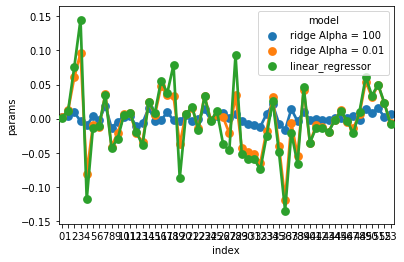

In [307]:
perf_lin = pd.DataFrame({"params": linear_regressor.coef_, 
                                       "model": "linear_regressor", 
                                       "index": range(0, len(X.columns))})

perf_ridge_large_alpha = pd.DataFrame({"params": ridge_regressor_large_alpha.coef_, 
                                       "model": "ridge Alpha = 100", 
                                       "index": range(0, len(X.columns))})

perf_ridge_small_alpha = pd.DataFrame({"params": ridge_regressor_small_alpha.coef_, 
                                       "model": "ridge Alpha = 0.01", 
                                       "index": range(0, len(X.columns))})

perf_compar = pd.concat([perf_ridge_large_alpha,perf_ridge_small_alpha,perf_lin])

import seaborn as sns
sns.pointplot(x = 'index',y = 'params',hue = 'model', data = perf_compar);

In the figure, we are able to notice the shrink even more.

8. Indetify the optimal value for the hyper-parameter alpha using sklearn function GridSearchCV, we will learn about the theory surrounding this function in the next lecture.
In the meantime, use it to try alpha values from 0 to 1000 with a step of 10, use a value of 10 as the "cv" parameter and a value of 2 for the "verbose" parameter.

In [308]:
from sklearn.model_selection import GridSearchCV

params = {'alpha':np.arange(0,1000,10)} # determine the range of parameters to try
ridge = Ridge() # create an instance of the model

grid = GridSearchCV(ridge, params, cv=10, verbose = 2)
grid_fit = grid.fit(X_train, y_train)

...................... alpha=850, total=   0.0s
[CV] alpha=860 .......................................................
[CV] ........................................ alpha=860, total=   0.0s
[CV] alpha=860 .......................................................
[CV] ........................................ alpha=860, total=   0.0s
[CV] alpha=860 .......................................................
[CV] ........................................ alpha=860, total=   0.0s
[CV] alpha=860 .......................................................
[CV] ........................................ alpha=860, total=   0.0s
[CV] alpha=860 .......................................................
[CV] ........................................ alpha=860, total=   0.0s
[CV] alpha=860 .......................................................
[CV] ........................................ alpha=860, total=   0.0s
[CV] alpha=860 .......................................................
[CV] ........................

In [309]:
grid_fit.best_params_

{'alpha': 910}

9. What is the score on the test set obtained using this optimal alpha parameter. Don't worry if it's a little under the scores obtained before, we will understand in the next lecture how this is nothing to worry about.

In [297]:
grid_fit.best_estimator_.score(X_test,y_test)

0.07075824990481694

10. Try going back to the beginning of the exercise and running it without extracting a small sample of data from the original dataset, do you get the same types of results? What does it tell you about ridge regression?

When increasing the number of samples in the data, it seems that ridge is not better than the linear regression model anymore, the penalization does not work. What does this tell us ? When using a relatively small sample of data ridge was better than linear regression, meaning linear regression's variance was too high and its bias was too low to derve good results on the test set, therefore the penalized version, ridge, git us better results. This is linked to the fact that a smaller sample of data naturally has lower variance than a bigger sample, therefore a model with lower variance is needed.

When increasing the number of sample back to normal, we increase the variance in the data dramatically. This increase in variance within the data calls for a model with higher variance and lower bias, which explains why, when all samples are selected, the results of ridge are not as convincing anymore.